<a href="https://colab.research.google.com/github/sakuyasophie/ChatPaper/blob/main/Data_driven_KPIs_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data-driven Energy Flexibility KPIs
This notebook contains the code we used to analyze the reviewed articles


In [ ]:
# Install dependencies
!pip install upsetplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for upsetplot: filename=UpSetPlot-0.6.1-py3-none-any.whl size=19089 sha256=9976043b12b067fab68254c27dcea5f1836f833c940918ec09a6231ca270f840
  Stored in directory: /root/.cache/pip/wheels/c5/b1/5a/7ba78fe55ccd48c7915805134ba69f152acae94cca3ff18e4c
Successfully built upsetplot


In [ ]:
# Get review summary from Google Sheet
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import plotly.express as px
import numpy as np

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1BYvYF_kVScc9upolPzEZHnIsrvBP2N2_1fS-nBxO2nI/edit?usp=sharing')

sheet_articles = wb.worksheet('Table A1')
sheet_kpis = wb.worksheet('Table A2')


In [ ]:
df_articles = pd.DataFrame(sheet_articles.get_all_values()).dropna()
df_articles.columns = df_articles.iloc[0]
df_articles = df_articles.iloc[1:, :]
df_articles.reset_index(drop=True, inplace=True)
len(df_articles['Article Title'].unique())

87

## Articles overview

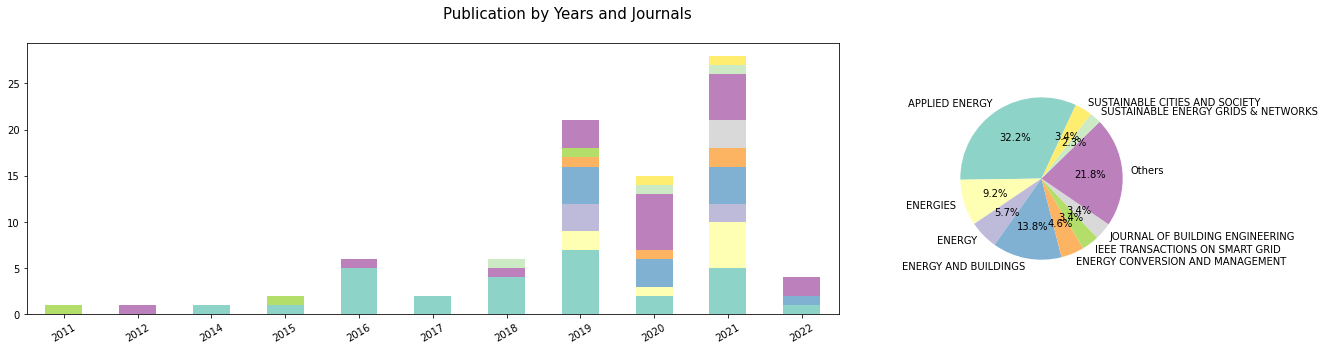

In [ ]:
popular_journals = df_articles['Source Title'].value_counts()[0:9].index.to_list()
df_articles['Source'] = df_articles['Source Title']
df_articles.loc[~df_articles['Source Title'].isin(popular_journals), 'Source'] = 'Others'
df_journals_by_year = pd.crosstab(index=df_articles['Publication Year'], columns=df_articles['Source'])
f, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [4, 1]})
df_journals_by_year.plot(kind='bar', stacked=True, rot=30, figsize=(20, 5), colormap='Set3', title='Publication Year', ax=axs[0], legend=False)
axs[0].set_xlabel('')
axs[0].set_title('')
f.suptitle('Publication by Years and Journals', size=15)

df_journal_agg = pd.DataFrame(df_articles['Source'].value_counts())
df_journal_agg['order'] = [1, 8, 4, 2, 3, 5, 7, 6, 10, 9]
df_journal_agg = df_journal_agg.sort_values(by='order', ascending=True)
df_journal_agg['Source'].plot(kind='pie', autopct='%1.1f%%', colormap='Set3', startangle=65, ylabel='', ax=axs[1])
f.savefig('year & source.png', dpi=300, bbox_inches='tight')

## Building sector, scope and assessment method

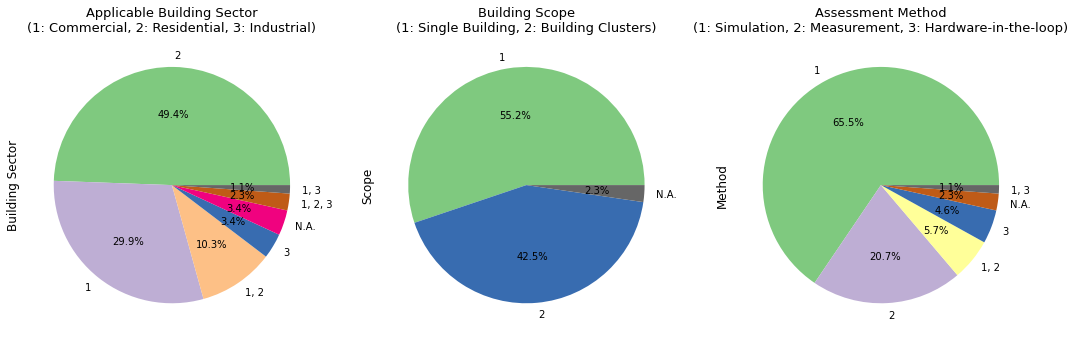

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

df_articles['Building Sector'].value_counts().plot(kind='pie', autopct='%1.1f%%', colormap='Accent', ax=axs[0])
df_articles['Scope'].value_counts().plot(kind='pie', autopct='%1.1f%%', colormap='Accent', ax=axs[1])
df_articles['Method'].value_counts().plot(kind='pie', autopct='%1.1f%%', colormap='Accent', ax=axs[2])

axs[0].set_ylabel('Building Sector', size=12)
axs[1].set_ylabel('Scope', size=12)
axs[2].set_ylabel('Method', size=12)
axs[0].set_title('Applicable Building Sector\n(1: Commercial, 2: Residential, 3: Industrial)', size=13)
axs[1].set_title('Building Scope\n(1: Single Building, 2: Building Clusters)', size=13)
axs[2].set_title('Assessment Method\n(1: Simulation, 2: Measurement, 3: Hardware-in-the-loop)', size=13)
print()

f.savefig('year & source.png', dpi=300, bbox_inches='tight')


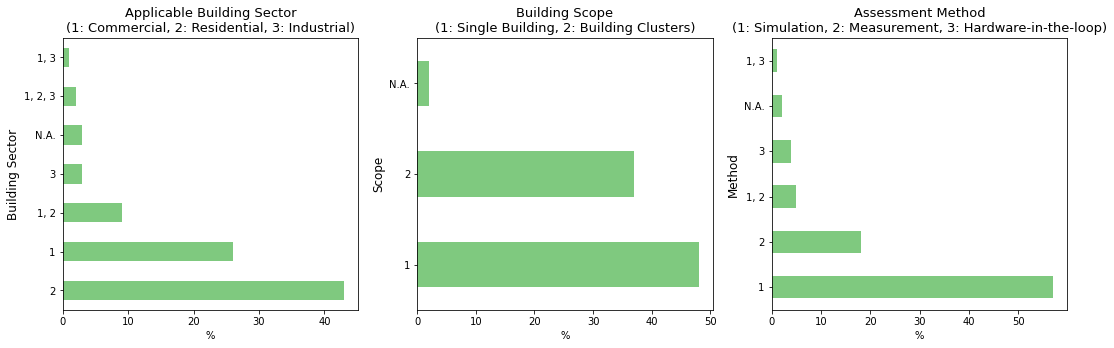

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].set_ylabel('Building Sector', size=12)
axs[1].set_ylabel('Scope', size=12)
axs[2].set_ylabel('Method', size=12)
axs[0].set_title('Applicable Building Sector\n(1: Commercial, 2: Residential, 3: Industrial)', size=13)
axs[1].set_title('Building Scope\n(1: Single Building, 2: Building Clusters)', size=13)
axs[2].set_title('Assessment Method\n(1: Simulation, 2: Measurement, 3: Hardware-in-the-loop)', size=13)
df_articles['Building Sector'].value_counts().plot(kind='barh', colormap='Accent', ax=axs[0])
df_articles['Scope'].value_counts().plot(kind='barh', colormap='Accent', ax=axs[1])
df_articles['Method'].value_counts().plot(kind='barh', colormap='Accent', ax=axs[2])
axs[0].set_xlabel('%')
axs[1].set_xlabel('%')
axs[2].set_xlabel('%')
# f.tight_layout()

f.savefig('figure_3.png', dpi=600, bbox_inches='tight')

## EF KPIs

In [ ]:
df_plot = df_articles

conditions = [
    (df_plot['KPI Needs Baseline?'] == 'Yes'),
    (df_plot['KPI Needs Baseline?'] == 'No'),
    (df_plot['KPI Needs Baseline?'] == 'N.A.'),
    (df_plot['KPI Needs Baseline?'] == 'Various')
]
choices = ['darkorange', 'cornflowerblue', 'lightgrey', 'rosybrown']
df_plot['color'] = np.select(conditions, choices, default='lightgrey')

## Detailed EF KPIs table analysis

In [ ]:

df_KPIs = pd.DataFrame(sheet_kpis.get_all_values()).iloc[3:, :]
df_KPIs.columns = df_KPIs.iloc[0]
df_KPIs = df_KPIs.iloc[1:, :]
df_KPIs = df_KPIs.loc[df_KPIs['#']!='']

df_KPIs_core = df_KPIs.loc[df_KPIs['Category'].str.startswith('EF KPI', na=False)]
df_KPIs_generic = df_KPIs.loc[df_KPIs['Category'].str.startswith('Generic', na=False)]


# Process DOE category values (x to True/False)
for doe_col in [c for c in df_KPIs_core.columns if 'DOE' in c]:
    df_KPIs_core.loc[df_KPIs_core[doe_col] != 'x', doe_col] = False
    df_KPIs_core.loc[df_KPIs_core[doe_col] == 'x', doe_col] = True

# Process performance aspect category values (x to True/False)
for per_col in [c for c in df_KPIs_core.columns if 'Performance Aspect' in c]:
    df_KPIs_core.loc[df_KPIs_core[per_col] != 'x', per_col] = False
    df_KPIs_core.loc[df_KPIs_core[per_col] == 'x', per_col] = True

# Process variable category values (x to True/False)
for var_col in [c for c in df_KPIs_core.columns if 'Variable' in c]:
    df_KPIs_core.loc[df_KPIs_core[var_col] != 'x', var_col] = False
    df_KPIs_core.loc[df_KPIs_core[var_col] == 'x', var_col] = True


# Check popularity, count KPIs by category
df_KPIs_core['Citations'] = [len(e.split(';')) for e in df_KPIs_core['Reference'].to_list()]
df_category_counts = pd.DataFrame(df_KPIs_core['Category'].value_counts())
for i, row in df_KPIs_core.iterrows():
    count = int(df_category_counts.loc[row['Category']])
    df_KPIs_core.at[i, 'Category'] = f"{row['Category']} ({count} KPIs)"


df_KPIs_core[['EF', 'New Category']] = df_KPIs_core['Category'].str.split('EF KPI: ', 1, expand=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pan

In [ ]:
import copy
def create_new_column_conditioned_on_old_column(df, old_col, new_col, dict_conditions, inplace=False, include_old_col=True):
    if not inplace:
        df = copy.deepcopy(df)
    conditions = []
    choices = []
    for old_col_val, new_col_val in dict_conditions.items():
        conditions.append(df[old_col] == old_col_val)
        if include_old_col:
            choices.append(f"{old_col_val} ({new_col_val})")
        else:
            choices.append(new_col_val)
    df[new_col] = np.select(conditions, choices, default=None)
    return df


## Add percentage to the dimensions for the parallel categorical plot
create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Relevance',
    'Relavance w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['Relevance'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Complexity',
    'Complexity w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['Complexity'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Need Baseline?',
    'Need Baseline? w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['Need Baseline?'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Temporal Evaluation Window',
    'Temporal Evaluation Window w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['Temporal Evaluation Window'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Temporal Data Resolution Requirement',
    'Temporal Data Resolution Requirement w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['Temporal Data Resolution Requirement'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'KPI Spacial / Geographical Resolution',
    'KPI Spacial / Geographical Resolution w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['KPI Spacial / Geographical Resolution'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'Need Baseline?',
    'KPI Type',
    {"Yes": "Baseline-required", "No": "Baseline-free"},
    True,
    False
)

create_new_column_conditioned_on_old_column(
    df_KPIs_core,
    'KPI Type',
    'KPI Type w/ %',
    {k: f"{str(round(v, 1))}%" for k, v in (df_KPIs_core['KPI Type'].value_counts(normalize=True)*100).to_dict().items()},
    True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3,Added in the doc?,#,Note,Category,KPI (raw),KPI,Reference,Definition,Formula,Terms,...,EF,New Category,Relavance w/ %,Complexity w/ %,Need Baseline? w/ %,Temporal Evaluation Window w/ %,Temporal Data Resolution Requirement w/ %,KPI Spacial / Geographical Resolution w/ %,KPI Type,KPI Type w/ %
4,Yes,1,Keep,EF KPI: Peak Power Shedding (4 KPIs),Peak power reduction,Peak Power Reduction,"Reynders et al., 2017; Afzalan et al., 2019; C...",Reduced power demand during peak hour due to f...,,,...,,Peak Power Shedding (4 KPIs),High (54.2%),Low (77.1%),Yes (81.2%),single event (54.2%),hourly (20.8%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
5,Yes,3,Keep,EF KPI: Peak Power Shedding (4 KPIs),Relative power demand reduction (for each hour),Hourly Relative Power Demand Reduction,"Yin et al., 2016",Relative reduced power demand for each hour of...,,,...,,Peak Power Shedding (4 KPIs),High (54.2%),Low (77.1%),Yes (81.2%),single event (54.2%),hourly (20.8%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
6,Yes,4,Keep,EF KPI: Peak Power Shedding (4 KPIs),Relative Peak power demand reduction,Relative Peak power demand reduction,"Lu et al., 2021; Afzalan et al., 2019; Muller ...",Percentage of power demand reduction during pe...,,,...,,Peak Power Shedding (4 KPIs),High (54.2%),Medium (10.4%),Yes (81.2%),single event (54.2%),hourly (20.8%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
7,,89,"Not sure about the relation b/w ""payback"" and ...",EF KPI: Peak Power Shedding (4 KPIs),Power Payback Ratio (PPR),Power Payback Ratio,"Zhang et al., 2019",Quantify variation of peak with / without DR -...,,,...,,Peak Power Shedding (4 KPIs),Medium (31.2%),Low (77.1%),Yes (81.2%),unspecified (18.8%),unspecified (79.2%),building cluster (16.7%),Baseline-required,Baseline-required (81.2%)
8,,6,Keep,EF KPI: Energy / Average Power Load Shedding (...,Energy deviation for peak shaving,Energy Deviation for Peak Shaving,"Lu et al., 2021",peak-shaving capacity,,,...,,Energy / Average Power Load Shedding (10 KPIs),High (54.2%),Low (77.1%),Yes (81.2%),single event (54.2%),unspecified (79.2%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
9,,8,Keep,EF KPI: Energy / Average Power Load Shedding (...,Average load reduction (by number of buildings),Average Load Reduction,"Ziras et al., 2019",Average load reduction during the demand respo...,,,...,,Energy / Average Power Load Shedding (10 KPIs),High (54.2%),Low (77.1%),Yes (81.2%),single event (54.2%),unspecified (79.2%),building cluster (16.7%),Baseline-required,Baseline-required (81.2%)
10,,10,Keep,EF KPI: Energy / Average Power Load Shedding (...,Building Energy Flexibility Index (BEFI),Building Energy Flexibility Index,"Lu et al., 2021; Athienitis et al., 2020; Date...",Calculating the average power reduction/increa...,,,...,,Energy / Average Power Load Shedding (10 KPIs),High (54.2%),Medium (10.4%),Yes (81.2%),single event (54.2%),unspecified (79.2%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
11,,13,Keep,EF KPI: Energy / Average Power Load Shedding (...,Dimensionless peak shaving,Dimensionless Peak Shaving,"Lu et al., 2021",represents the energy reduction percentage of ...,,,...,,Energy / Average Power Load Shedding (10 KPIs),Low (14.6%),Low (77.1%),Yes (81.2%),single event (54.2%),unspecified (79.2%),unspecified (56.2%),Baseline-required,Baseline-required (81.2%)
12,No,72,Keep,EF KPI: Energy / Average Power Load Shedding (...,Load factor/peak to average ratio,Load Factor,"Aziz et al., 2021; Razmara et al., 2017",dividing the average load to the peak load in ...,,,...,,Energy / Average Power Load Shedding (10 KPIs),Low (14.6%),Low (77.1%),No (18.8%),single event (54.2%),unspecified (79.2%),unspecified (56.2%),Baseline-free,Baseline-free (18.8%)
13,No,78,Keep,EF KPI: Energy / Average Power Load Shedding (...,Annual average daily heat or electricity load ...,Annual Average Daily Load Variation,"Kristensen and Petersen, 2020",An i

### 1. Parallel plot with all core KPIs

In [ ]:
fig = px.parallel_categories(
    # df_KPIs_core.loc[df_KPIs_core['Need Baseline?'] == 'Yes', cols_to_keep],
    # df_KPIs_core.loc[df_KPIs_core['Need Baseline?'] == 'No', cols_to_keep],
    df_KPIs_core,
    dimensions=['New Category', 'KPI', 'Relavance w/ %', 'Complexity w/ %', 'KPI Type w/ %', "Temporal Evaluation Window w/ %", "Temporal Data Resolution Requirement w/ %", "KPI Spacial / Geographical Resolution w/ %"],
    height=800,
    color="Citations",
    color_continuous_scale='dense',
    # color_continuous_scale='amp',
    labels={
        'New Category': 'Category',
        'Relavance w/ %': 'Relevance',
        'Complexity w/ %': 'Complexity',
        'KPI Type w/ %': 'KPI Type',
        'Temporal Evaluation Window w/ %': 'Evaluation Window',
        'Temporal Data Resolution Requirement w/ %': 'Temporal Data Resolution',
        'KPI Spacial / Geographical Resolution w/ %': 'Spatial Resolution'
    }
)

dimensions = list(range(8))
fig.update_traces(dimensions=[{"categoryorder": "category descending"} for _ in dimensions])
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    margin=dict(l=320, r=200, t=20, b=20),
    # paper_bgcolor="LightSteelBlue",
)

fig.show()


### 2. Analysis of baseline-needed KPIs

In [ ]:
from upsetplot import plot
from upsetplot import generate_counts
from upsetplot import from_memberships
from upsetplot import UpSet
from matplotlib import cm

39 baseline-required KPIs are identified.
----------------------------------------------------------------------------------------------------


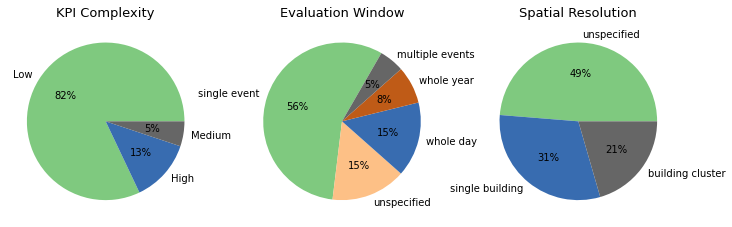

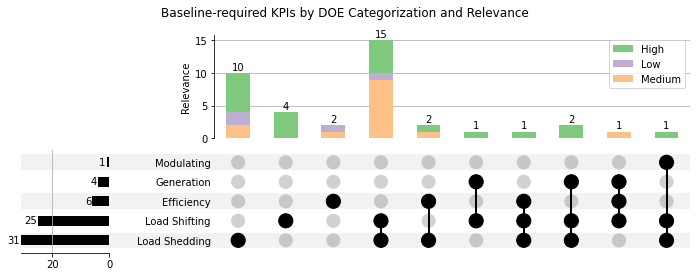

In [ ]:
df_KPIs_core_bn = df_KPIs_core.loc[df_KPIs_core['Need Baseline?'] == 'Yes']

print(f"{len(df_KPIs_core_bn.index)} baseline-required KPIs are identified.")
print('-'*100)


f, axs = plt.subplots(1, 3, figsize=(12, 4))
# df_KPIs_core_bn['Relevance'].value_counts().plot(kind='pie', autopct='%1.1f%%', colormap='Accent', ax=axs[0])
df_KPIs_core_bn['Complexity'].value_counts().plot(kind='pie', autopct='%1.0f%%', colormap='Accent', ax=axs[0])
df_KPIs_core_bn['Temporal Evaluation Window'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=60, colormap='Accent', ax=axs[1])
df_KPIs_core_bn['KPI Spacial / Geographical Resolution'].value_counts().plot(kind='pie', autopct='%1.0f%%', colormap='Accent', ax=axs[2])

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('KPI Complexity', size=13)
axs[1].set_title('Evaluation Window', size=13)
axs[2].set_title('Spatial Resolution', size=13)
# plt.savefig("baseline_required.png", dpi=600, bbox_inches='tight')
plt.savefig("figure_6.png", dpi=600, bbox_inches='tight')

# ------------------------------------------------------------------------------
# Upset plot
ls_per_cols = [c for c in df_KPIs_core.columns if 'DOE' in c]
ls_per_cats = []
for i, row in df_KPIs_core_bn.iterrows():
    per_cat = [col.split(' - ')[1] for col in ls_per_cols if row[col]]
    ls_per_cats.append(per_cat)
df_performance = pd.DataFrame(from_memberships(ls_per_cats, data=df_KPIs_core_bn[['Citations', 'Relevance', 'Need Baseline?']]))

fig = plt.figure(figsize=(12, 4))
upset = UpSet(df_performance, intersection_plot_elements=0, show_counts='%d', element_size=None)  # disable the default bar chart

upset.add_stacked_bars(by="Relevance", colors=cm.Accent,
                       title="Relevance", elements=5)
upset.plot(fig=fig)
plt.suptitle('Baseline-required KPIs by DOE Categorization and Relevance')
# plt.savefig("baseline_required_upset.png", dpi=600, bbox_inches='tight')
plt.savefig("figure_5.png", dpi=600, bbox_inches='tight')





### 3. Analysis of baseline-free KPIs

9 baseline-free KPIs are identified.
13                               Load Factor
14       Annual Average Daily Load Variation
24           Energy Shift Flexibility Factor
25                        Flexibility Factor
27         Flexibility Classification Factor
29                   Cycle Power Flexibility
32                                      Ramp
35                 Available Flexible Energy
48    Flexibility Aggregation Synergy Factor
Name: KPI, dtype: object
----------------------------------------------------------------------------------------------------


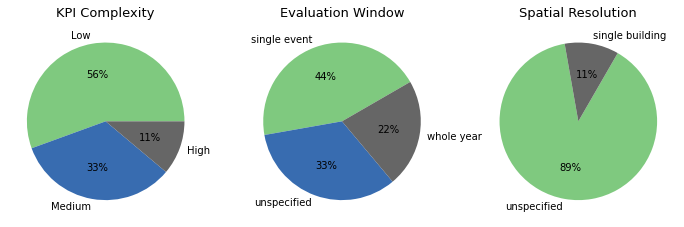

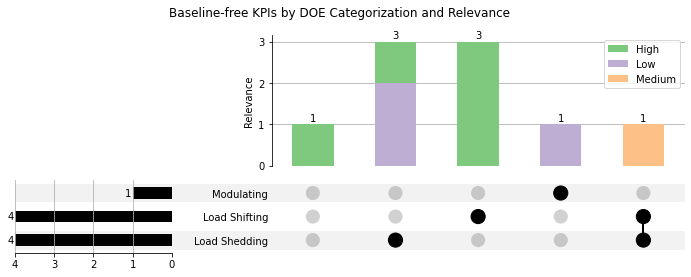

In [ ]:
df_KPIs_core_bf = df_KPIs_core.loc[df_KPIs_core['Need Baseline?'] == 'No']

print(f"{len(df_KPIs_core_bf.index)} baseline-free KPIs are identified.")
print(df_KPIs_core_bf['KPI'])
print('-'*100)

f, axs = plt.subplots(1, 3, figsize=(12, 4))

df_KPIs_core_bf['Complexity'].value_counts().plot(kind='pie', autopct='%1.0f%%', colormap='Accent', ax=axs[0])
df_KPIs_core_bf['Temporal Evaluation Window'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=30, colormap='Accent', ax=axs[1])
df_KPIs_core_bf['KPI Spacial / Geographical Resolution'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=100, colormap='Accent', ax=axs[2])

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('KPI Complexity', size=13)
axs[1].set_title('Evaluation Window', size=13)
axs[2].set_title('Spatial Resolution', size=13)
f.show()
# f.savefig("baseline_free.png", dpi=600, bbox_inches='tight')
plt.savefig("figure_7.png", dpi=600, bbox_inches='tight')

# ------------------------------------------------------------------------------
# Upset plot
ls_per_cols = [c for c in df_KPIs_core.columns if 'DOE' in c]
ls_per_cats = []
for i, row in df_KPIs_core_bf.iterrows():
    per_cat = [col.split(' - ')[1] for col in ls_per_cols if row[col]]
    ls_per_cats.append(per_cat)
df_performance = pd.DataFrame(from_memberships(ls_per_cats, data=df_KPIs_core_bf[['Citations', 'Relevance']]))

fig = plt.figure(figsize=(12, 4))
upset = UpSet(df_performance, intersection_plot_elements=0, show_counts='%d', element_size=None)  # disable the default bar chart

upset.add_stacked_bars(by="Relevance", colors=cm.Accent,
                       title="Relevance", elements=5)
upset.plot(fig=fig)
plt.suptitle('Baseline-free KPIs by DOE Categorization and Relevance')
# plt.show()
# plt.savefig("baseline_free_upset.png", dpi=600, bbox_inches='tight')
plt.savefig("figure_8.png", dpi=600, bbox_inches='tight')



Text(0.5, 0.98, 'Number of KPIs by Performance Aspects')

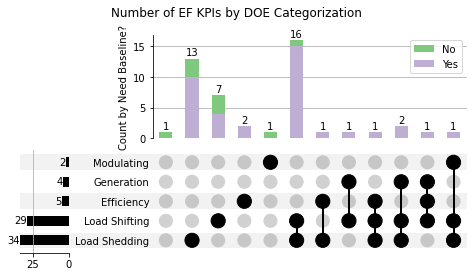

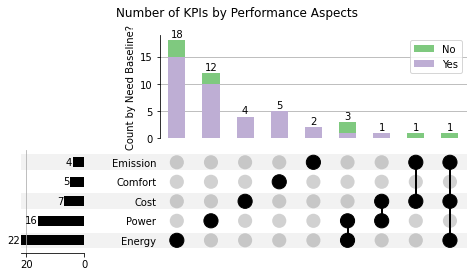

In [ ]:
# Upset plots by "Need Baseline?"
## By DOE categorization
ls_doe_cols = [c for c in df_KPIs_core.columns if 'DOE' in c]
ls_doe_cats = []
for i, row in df_KPIs_core.iterrows():
    # doe_cat = [col if row[col] else '' for col in ls_doe_cols]
    doe_cat = [col.split(' - ')[1] for col in ls_doe_cols if row[col]]
    ls_doe_cats.append(doe_cat)
    # print(doe_cat)

# df_doe_cat = pd.DataFrame(from_memberships(ls_doe_cats, data=df_KPIs_core[['Popularity']]))
# fig = plt.figure(figsize=(8, 4))

# plot(df_doe_cat, subset_size='count', show_counts='%d', fig=fig, element_size=None)
# # plot(ee, subset_size='count', show_counts='%d', element_size=None)
# plt.suptitle('Number of EF KPIs by DOE Categorization')

# plt.savefig('doe categories.png', dpi=600, bbox_inches='tight')
# plt.show()


df_doe_cat = pd.DataFrame(from_memberships(ls_doe_cats, data=df_KPIs_core[['Citations', 'Relevance', 'Need Baseline?']]))
fig = plt.figure(figsize=(8, 4))
upset = UpSet(df_doe_cat, intersection_plot_elements=0, show_counts='%d', element_size=None)  # disable the default bar chart

upset.add_stacked_bars(by="Need Baseline?", colors=cm.Accent,
                       title="Count by Need Baseline?", elements=5)
upset.plot(fig=fig)
plt.suptitle('Number of EF KPIs by DOE Categorization')
# plt.savefig('doe_categories.png', dpi=600, bbox_inches='tight')

# ------------------------------------------------------------------------------
## By performance aspects
ls_per_cols = [c for c in df_KPIs_core.columns if 'Performance Aspect' in c]
ls_per_cats = []
for i, row in df_KPIs_core.iterrows():
    per_cat = [col.split(' - ')[1] for col in ls_per_cols if row[col]]
    ls_per_cats.append(per_cat)


df_performance = pd.DataFrame(from_memberships(ls_per_cats, data=df_KPIs_core[['Citations', 'Relevance', 'Need Baseline?']]))

fig = plt.figure(figsize=(8, 4))
upset = UpSet(df_performance, intersection_plot_elements=0, show_counts='%d', element_size=None)  # disable the default bar chart

upset.add_stacked_bars(by="Need Baseline?", colors=cm.Accent,
                       title="Count by Need Baseline?", elements=5)
upset.plot(fig=fig)
plt.suptitle('Number of KPIs by Performance Aspects')
# plt.savefig('performance_aspects.png', dpi=600, bbox_inches='tight')


In [ ]:

len(df_KPIs_core)
len(df_KPIs_generic)

29

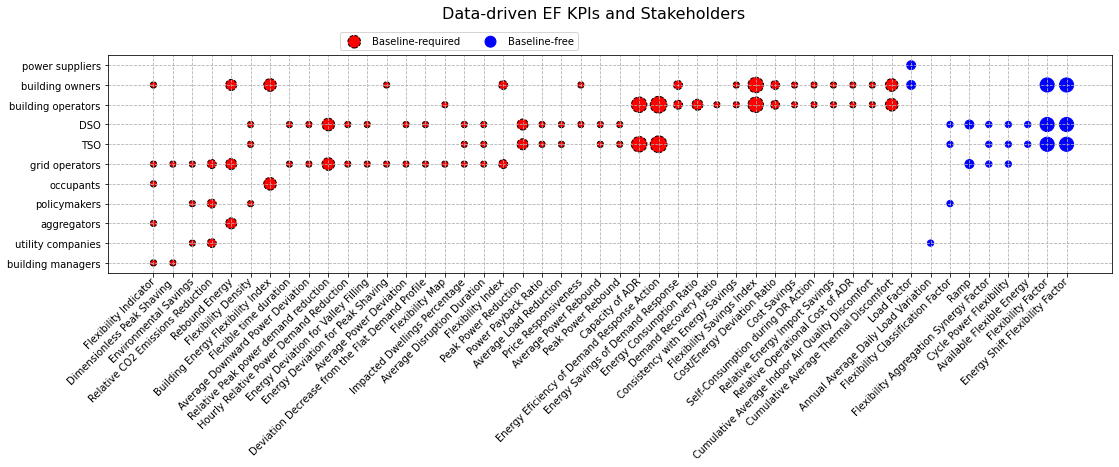

In [ ]:
ls_new_rows = []
for i, row in df_KPIs_core.iterrows():
    new_rows = [[row['KPI'], s, row['Citations'], row['Need Baseline?']] for s in row['Stakeholders'].split('; ')]
    ls_new_rows.extend(new_rows)

df_KPI_stakeholder = pd.DataFrame.from_records(ls_new_rows)
df_KPI_stakeholder.columns = ['KPIs', 'Stakeholders', 'Number of Citations', 'Need Baseline?']
df_KPI_stakeholder.loc[df_KPI_stakeholder['Need Baseline?'] == 'Yes', 'color'] = 'r'
df_KPI_stakeholder.loc[df_KPI_stakeholder['Need Baseline?'] == 'No', 'color'] = 'b'

df_total_stk = df_KPI_stakeholder[['Stakeholders', 'Number of Citations']].groupby('Stakeholders').sum()
df_total_stk.columns = ['Total Popularity']
df_total_stk = df_total_stk.reset_index()
df_KPI_stakeholder = pd.merge(df_KPI_stakeholder, df_total_stk, on='Stakeholders')
df_KPI_stakeholder = df_KPI_stakeholder.sort_values(by='Total Popularity')
df_total_stk = df_total_stk.set_index('Stakeholders').sort_values(by='Total Popularity')

df_KPI_stakeholder_bn = df_KPI_stakeholder.loc[df_KPI_stakeholder['Need Baseline?'] == 'Yes']
df_KPI_stakeholder_bf = df_KPI_stakeholder.loc[df_KPI_stakeholder['Need Baseline?'] == 'No']

f, ax = plt.subplots(1, 1, figsize=(18, 4))

# s1 = ax.scatter(df_KPI_stakeholder_bn['KPIs'], df_KPI_stakeholder_bn['Stakeholders'], s=df_KPI_stakeholder_bn['Number of Citations']*40, c=df_KPI_stakeholder_bn['color'], label='Baseline-required', edgecolor='k', marker='$\u25CC$')
s1 = ax.scatter(df_KPI_stakeholder_bn['KPIs'], df_KPI_stakeholder_bn['Stakeholders'], s=df_KPI_stakeholder_bn['Number of Citations']*40, c=df_KPI_stakeholder_bn['color'], label='Baseline-required', edgecolor='k', linestyle='--')
s2 = ax.scatter(df_KPI_stakeholder_bf['KPIs'], df_KPI_stakeholder_bf['Stakeholders'], s=df_KPI_stakeholder_bf['Number of Citations']*40, c=df_KPI_stakeholder_bf['color'], label='Baseline-free')

ax.tick_params(axis='x', bottom=True, right=True, labelbottom=True, labelright=True)
ax.grid(ls = "--", zorder = 1)
f.suptitle('Data-driven EF KPIs and Stakeholders', size=16, y=1.05)
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")


classes = ['Baseline-required', 'Baseline-free']
plt.legend(loc='lower center', bbox_to_anchor=(0.35, 1), fancybox=True, ncol=2)
# plt.show()
plt.savefig('stakeholder_popularity.png', dpi=600, bbox_inches='tight')

